![image](how.png)

**"Should I Stay or Should i Go (from the Hospital)"**

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (10,8)
# Load libraries

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from xgboost import XGBClassifier 
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RepeatedKFold, KFold
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import LabelEncoder 
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from pandas_profiling import ProfileReport

# progress bar 
from tqdm import tqdm

import pickle

from utils.files import rename_filename, file_exists

import warnings
warnings.filterwarnings('ignore')

In [2]:
# GLOBAL VARIABLES 

number_of_processors = -4  # -1 all, -2 all but one, ...
seed = 9
# baseline

In [3]:
df = pd.read_csv("healthcare/train_set.csv")

In [4]:
# PAra mostrar la distrubución de las variables en gráficas

sns.pairplot(df)

Error in callback <function flush_figures at 0x00000267E6154378> (for post_execute):


KeyboardInterrupt: 

In [ ]:
pr = ProfileReport(df, title='Pandas Profiling Report')
pr

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 18 columns):
0     100000 non-null int64
1     100000 non-null int64
2     100000 non-null object
3     100000 non-null int64
4     100000 non-null object
5     100000 non-null int64
6     100000 non-null object
7     100000 non-null object
8     100000 non-null object
9     99967 non-null float64
10    100000 non-null int64
11    98517 non-null float64
12    100000 non-null object
13    100000 non-null object
14    100000 non-null int64
15    100000 non-null object
16    100000 non-null float64
17    100000 non-null object
dtypes: float64(3), int64(6), object(9)
memory usage: 13.7+ MB


In [5]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,161528,6,a,6,X,2,gynecology,R,F,4.0,45810,2.0,Urgent,Moderate,2,21-30,2817.0,0-10
1,159472,23,a,6,X,4,gynecology,Q,F,2.0,128565,15.0,Trauma,Moderate,4,51-60,4498.0,21-30
2,309765,2,c,5,Z,2,anesthesia,S,F,3.0,46565,5.0,Urgent,Moderate,2,71-80,4573.0,11-20
3,279614,32,f,9,Y,3,gynecology,S,B,4.0,124546,6.0,Emergency,Moderate,4,11-20,7202.0,51-60
4,147791,14,a,1,X,3,gynecology,S,E,2.0,22729,8.0,Urgent,Moderate,2,51-60,3398.0,51-60


In [6]:
# PROBLEMA DE CLASIFICACIÓN
df["17"].value_counts()

21-30                 27452
11-20                 24476
31-40                 17311
51-60                 10984
0-10                   7427
41-50                  3668
71-80                  3297
More than 100 Days     2150
81-90                  1470
91-100                  908
61-70                   857
Name: 17, dtype: int64

In [7]:
# esto es necesario para evitar futuros errores pero si quitaráis las columnas con Nan no haría falta
# Nan no vale pero 0 sí
#df = df.dropna()
# esto quita filas y por tanto no se lo podremos aplicar al dataset de predicción

In [8]:
# quitad la primera columna porque corresponde con el case_id y por tanto no le servirá al modelo para aprender...
# quitar otras columnas es decisión vuestra como futuros data scientists 
df.drop("0",1,inplace = True)

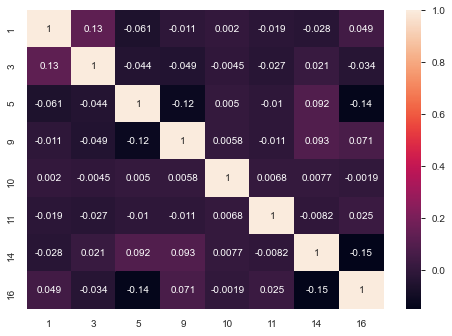

In [9]:
# Matriz de correlación
# No encuentro mucha correlación. Entrenaré con todos los datos
corrMatrix = df.corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

In [10]:
na_ratio = ((df.isnull().sum() / len(df))*100).sort_values(ascending = False)
print(na_ratio)

11    1.483
9     0.033
8     0.000
2     0.000
3     0.000
4     0.000
5     0.000
6     0.000
7     0.000
17    0.000
16    0.000
10    0.000
12    0.000
13    0.000
14    0.000
15    0.000
1     0.000
dtype: float64


#### 1. Definir X e y

In [11]:
X = df.drop(columns=["17"])
X

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,6,a,6,X,2,gynecology,R,F,4.0,45810,2.0,Urgent,Moderate,2,21-30,2817.0
1,23,a,6,X,4,gynecology,Q,F,2.0,128565,15.0,Trauma,Moderate,4,51-60,4498.0
2,2,c,5,Z,2,anesthesia,S,F,3.0,46565,5.0,Urgent,Moderate,2,71-80,4573.0
3,32,f,9,Y,3,gynecology,S,B,4.0,124546,6.0,Emergency,Moderate,4,11-20,7202.0
4,14,a,1,X,3,gynecology,S,E,2.0,22729,8.0,Urgent,Moderate,2,51-60,3398.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,12,a,9,Y,3,gynecology,R,B,3.0,82914,3.0,Emergency,Moderate,6,51-60,3966.0
99996,28,b,11,X,2,gynecology,R,F,2.0,40026,5.0,Urgent,Moderate,3,21-30,4005.0
99997,6,a,6,X,3,gynecology,Q,F,3.0,92346,2.0,Trauma,Minor,2,31-40,5215.0
99998,32,f,9,Y,2,gynecology,S,B,4.0,113798,15.0,Trauma,Moderate,3,41-50,5092.0


In [12]:
X.shape

(100000, 16)

In [13]:
y = df['17']
y

0                      0-10
1                     21-30
2                     11-20
3                     51-60
4                     51-60
                ...        
99995    More than 100 Days
99996                 51-60
99997                 31-40
99998                 11-20
99999                 41-50
Name: 17, Length: 100000, dtype: object

¿ Tenemos outliers ? Detectarlos y eliminarlos es otra buena opción.

In [15]:
# encoder
le = LabelEncoder()

# Data mining:
def normalize_dataframe(df):
    scaler = MinMaxScaler()
    df_normalized = pd.DataFrame(
        data=scaler.fit_transform(df.values), 
        columns=df.columns, 
        index=df.index)
    return df_normalized

# Esta función debería ser usada al principio del todo ya que se realizan los cambios de la misma manera.
def my_transformation(df, norm=False, drop_nans=True, my_decision=0):
    """
    Esta función utiliza un dataframe original, y lo modifica para retornar el dataframe con todos los cambios realizados que hemos creído convenientes.
    """
    df_modified = df.copy()
    if drop_nans:
        # 1. Elimino columna 9 y 11 por tener nan
        df_modified.drop(["9", "11"], 1, inplace=True)
    else:
        # Convierto NaNs a la mean de esas columnas
        df_modified["9"] = df_modified["9"].fillna(df_modified["9"].mean())
        df_modified["11"] = df_modified["11"].fillna(df_modified["11"].mean())

    # 2, 3 y 4. Realizo el encoder de las categóricas además de normalizar
    # 2.Paso las columnas "Object" a numéricas
    X_categorical_no_numbers = df_modified[df_modified.select_dtypes('object').columns].apply(le.fit_transform)
    # 3. Cojo solo columnas numéricas
    X_others = df_modified.select_dtypes(exclude=['object'])
    if norm:
        # 4. Normalizo las columnas numéricas
        X_others = normalize_dataframe(df=X_others)
    # 5. Concateno el resultado final
    df_modified = pd.concat([X_others, X_categorical_no_numbers], axis=1)

    if my_decision == 1:
        # me quedo solo con las columnas: 
        # [admission_deposit, city_code_patient, age, hospital_code, available extra rooms in hospital, hospital_type_code_feat_hospital_code, visitors_with_patient, bed grade, severity of illness]
        df_modified = df_modified[["16","11", "15", "13", "14", "1", "5", "2", "9"]]

    return df_modified

In [16]:
X_modified = my_transformation(df=df)
X_modified

,1,3,5,10,14,16,2,4,6,7,8,12,13,15,17
0,6,6,2,45810,2,2817.0,0,0,2,2,5,2,2,2,0
1,23,6,4,128565,4,4498.0,0,0,2,1,5,1,2,5,2
2,2,5,2,46565,2,4573.0,2,2,1,3,5,2,2,7,1
3,32,9,3,124546,4,7202.0,5,1,2,3,1,0,2,1,5
4,14,1,3,22729,2,3398.0,0,0,2,3,4,2,2,5,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,12,9,3,82914,6,3966.0,0,1,2,2,1,0,2,5,10
99996,28,11,2,40026,3,4005.0,1,0,2,2,5,2,2,2,5
99997,6,6,3,92346,2,5215.0,0,0,2,1,5,1,1,3,3
99998,32,9,2,113798,3,5092.0,5,1,2,3,1,1,2,4,1


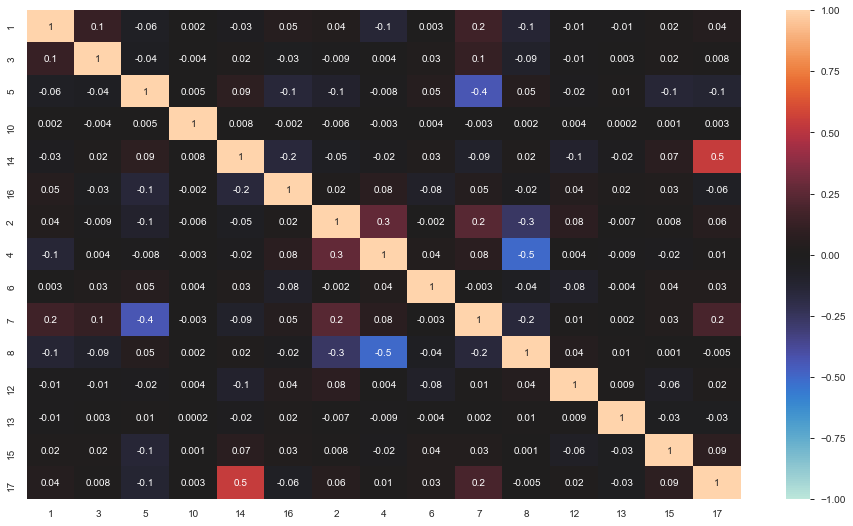

In [17]:
# Si queremos visualizar la matriz de correlación con todos los datos incluyendo el target, mostraremos la matriz de correlación antes de quitar "y" del dataframe.

# Segunda Matriz de correlación
# No encuentro mucha correlación. Entrenaré con todos los datos
plt.figure(figsize = (16,9))

sns.heatmap(X_modified.corr(),annot = True,fmt='.1g', vmin=-1, vmax=1, center= 0, linecolor='green')

In [18]:
# Ahora elimino de nuestra X modificada la columna target
X_modified.drop(columns=["17"], inplace=True)
X_modified

,1,3,5,10,14,16,2,4,6,7,8,12,13,15
0,6,6,2,45810,2,2817.0,0,0,2,2,5,2,2,2
1,23,6,4,128565,4,4498.0,0,0,2,1,5,1,2,5
2,2,5,2,46565,2,4573.0,2,2,1,3,5,2,2,7
3,32,9,3,124546,4,7202.0,5,1,2,3,1,0,2,1
4,14,1,3,22729,2,3398.0,0,0,2,3,4,2,2,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,12,9,3,82914,6,3966.0,0,1,2,2,1,0,2,5
99996,28,11,2,40026,3,4005.0,1,0,2,2,5,2,2,2
99997,6,6,3,92346,2,5215.0,0,0,2,1,5,1,1,3
99998,32,9,2,113798,3,5092.0,5,1,2,3,1,1,2,4


#### 2. Dividir X_train, X_test, y_train, y_test

In [19]:
# Primero genero un X_train muy muy pequeño simplemente para probar que funciona todo OK
X_train_SAMPLE, X_test_SAMPLE, y_train_SAMPLE, y_test_SAMPLE = train_test_split(X_modified.values, y.values, test_size=0.99, random_state=seed)

In [20]:
X_train_SAMPLE.shape

(1000, 14)

In [21]:
X_test_SAMPLE.shape

(99000, 14)

In [22]:
# Este es la división formal de los datos
X_train, X_test, y_train, y_test = train_test_split(X_modified.values, y.values, test_size=0.2, random_state=seed)
X_train.shape

(80000, 14)

In [23]:
# Podemos quitar de la memoria las variables que no estemos utilizando con "del"
del df

In [24]:
def save_model(to_save, filepath):
    try:
        if file_exists(filepath=filepath):
            filepath = rename_filename(filepath=filepath)
        pickle.dump(to_save, open(filepath, 'wb'))
        print("Saved successfully")
        return True, filepath
    except Exception as e:
        print("Error during saving model:\n", e)
        return False, filepath

#### 3. Genero el modelo, en este caso estoy usando GridSearch

In [37]:
# Create a pipeline

verbose = True # Si queremos que muestre más información durante el entrenamiento

logistic_params = {
    'classifier': [LogisticRegression(verbose=verbose, n_jobs=number_of_processors)],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__C': np.logspace(0, 4, 10),
    #'classifier__solver': {'newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'},
    }

random_forest_params = {
    'classifier': [RandomForestClassifier(verbose=verbose, n_jobs=number_of_processors, warm_start=True)],
    'classifier__n_estimators': [10, 100, 1000, 10000],
    'classifier__max_features': [6,7]
    }

svm_params = {
    'classifier': [svm.SVC(verbose=False)],
    'classifier__kernel':(['rbf']), 
    'classifier__C':[-10, -1, 0.5, 1,10],
    'classifier__coef0': [-1., 0.1, 0.5, 1, ],
    'classifier__gamma': (['auto'])
    }

xgboost_params = {
    'classifier': [XGBClassifier(n_jobs=number_of_processors)],
    'classifier__max_delta_step':[0.1, 0, 0.2, 1.],
    'classifier__max_depth': [6, 8, 10, 12, 14]
    }

knn_params = {
    'classifier': [KNeighborsClassifier()],
    'classifier__n_neighbors':[7, 8, 9, 10, 11],
}

#from xgboost import plot_importance
#plot_importance(model)

# Create space of candidate learning algorithms and their hyperparameters
search_space = [
    logistic_params,
    #random_forest_params,
    #svm_params,
    #xgboost_params,
    #knn_params,
    ]

# Le podemos poner cualquier clasificador. Irá cambiando según va probando pero necesita 1.
# Si solo vamos a usar uno, debemos poner aquí que vamos a usar ese.
pipe = Pipeline(steps=[('classifier', logistic_params["classifier"][0])])

In [38]:
# save the model to disk
pipeline_filename = 'models/best_models_pipeline.sav'
model_filename = 'models/best_model.sav'

In [66]:
%%time

# Booleano que cambiaré cuando quiera probar con datos de prueba o con datos formales
sample = True

cv = RepeatedKFold(n_splits=5, n_repeats=1, random_state=seed)

# Create grid search 
clf = GridSearchCV(estimator=pipe, param_grid=search_space, cv=cv, verbose=10, n_jobs=number_of_processors)

if sample:
    # Fit grid search -- CON DATOS SAMPLE
    best_models_pipeline = clf.fit(X_train_SAMPLE, y_train_SAMPLE)
else:
    # Para todos los datos
    best_models_pipeline = clf.fit(X_train, y_train)
print("Model trained!")


# View best model
separator = "\n############################\n"
print(separator)
print("best estimator:", best_models_pipeline.best_estimator_.get_params()['classifier'])
print(separator)
print("clf.best_params_", clf.best_params_)
print(separator)
# Mean cross-validated score of the best_estimator
print("clf.best_score", clf.best_score_)

# Esta variable representa la clase del mejor modelo que ha encontrado y parcialmente entrenado*. 
best_model = best_models_pipeline.best_estimator_.get_params()['classifier']

#SAVE MODEL
success, pipeline_filename = save_model(to_save=best_models_pipeline, filepath=pipeline_filename)
success, model_filename = save_model(to_save=best_model, filepath=model_filename)

print("End GridSearch")

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[Parallel(n_jobs=-4)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-4)]: Done   3 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-4)]: Done   8 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-4)]: Done  15 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-4)]: Batch computation too fast (0.1952s.) Setting batch_size=2.
[Parallel(n_jobs=-4)]: Done  22 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-4)]: Batch computation too fast (0.1117s.) Setting batch_size=4.
[Parallel(n_jobs=-4)]: Done  33 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-4)]: Batch computation too fast (0.1057s.) Setting batch_size=8.
[Parallel(n_jobs=-4)]: Done  52 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-4)]: Done  82 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-4)]: Done  91 out of 100 | elapsed:    1.6s remaining:    0.1s
[Parallel(n_jobs=-4)]: Done 100 out of 100 | elapsed:    1.8s finished
[Parallel(n_jobs=-4)]: Usin

Si durante el proceso se para o tarda mucho y el PC funciona más lento a partir de este momento, sería conveniente mirar los procesos que está ejecutuando tu sistema operativo. 

- En W10 tenemos el administrador de tareas.
- En Mac tenemos el monitor de actividades.

Si detectamos que existen muchos procesos "python" incluso después de parar nuestro jupyter, tenemos que eliminar todos esos procesos:

- En windows 10, podemos ir eliminando cada proceso "python.exe" desde el administrador de programas o ejecutando el script "kill_python.bat". IMPORTANTE: Hay que ejecutarlo con permisos de administrador.

- En mac o linux, tenemos que ejecutar en la línea de comandos una de las siguientes opciones:

    1. pkill -f python
    2. killall python
    3. ps aux | grep python | grep -v grep | awk '{print $2}'
    4. kill $(ps aux | grep python | grep -v grep | awk '{print $2}')

    - En el punto 4 realmente hay un $

Todo lo que hemos hecho antes, lo tenemos guardado en un archivo que podemos usarlo donde queramos sin necesidad del código anterior. 

En este caso, como es una competición y vamos a realizar un submission final, necesitaremos parte de las transformaciones que le hemos hecho a nuestro dataset para poder realizárselo al conjunto final de test que nos proporciona Kaggle.

#### Si necesitamos cargar el modelo guardado

In [80]:
# Para cargar el modelo

with open(file=model_filename, mode="rb") as model_save:
    model = pickle.load(model_save)
type(model)

sklearn.linear_model._logistic.LogisticRegression

#### Cuando se utiliza pipeline, se puede coger la clase del modelo que ha sido probado con las mejores features y parcialmente entrenado* así:

    best_model.best_estimator_.get_params()['classifier']

In [42]:
# Esta variable "model" representa la clase de nuestro modelo con los mejores parámetros encontrados por GridSearch

# Anteriormente, llamamos best_model al modelo que salió de GridSearch, por eso lo renombramos de nuevo. Si no hemos hecho el grid search, esta celda dará error.
model = best_model

#### 4. (Opción 1) Entrenar el modelo con X_train, y_train

In [25]:
# De esta forma, instanciamos una clase nueva que no tiene los datos entrenados.
model = LogisticRegression(n_jobs=-4, verbose=True, C=1., penalty="l2", warm_start=True)

In [68]:
%%time
# Opción para entrenar con todo a la vez
model.fit(X_train, y_train)
print("Entrenamiento finalizado!")

success, model_filename = save_model(to_save=model, filepath=model_filename)

[Parallel(n_jobs=-4)]: Using backend LokyBackend with 5 concurrent workers.
Entrenamiento finalizado!
Saved successfully
Wall time: 6.1 s
[Parallel(n_jobs=-4)]: Done   1 out of   1 | elapsed:    5.9s finished


### Cross validation usando todos los datos

### IMPORTANTE PARA ENTRENAMIENTOS EN CROSS VALIDATION

**NO TODOS LOS MODELOS PERMITEN EL ENTRENAMIENTO EN CALIENTE (ONLINE, INCREMENTAL, POR LOTES, MINI_BATCH)**

Es absolutamente OBLIGATORIO buscar el método o atributo que realiza entrenamientos "en caliente" o "incrementales" para nuestro modelo. 

Normalmente, en Scikitlearn tenemos el parámetro de entrada "warm_start", pero no siempre se llama igual. 

También, podría no ser un parámetro y una forma de llamar al método "fit" como "fit_batch". 

Esto que tenemos abajo es como debería entrenarse nuestro modelo con cross_validation. 

#### (Opción 2) 

Esta es la opción para usar todos los datos de nuestro dataset a la vez por cada Epoch. 
No es recomendable si tenemos recursos limitados. Ahora bien, podemos arreglarlo pasándole los datos poco a poco. (más abajo)

In [97]:
%%time

restart_from_beggining = False
if restart_from_beggining:
    # de esta forma, estamos haciendo que nuestro modelo pierda el anterior fit de datos durante gridsearch y empiece de 0 el entrenamiento. Usamos las mejores features encontradas.
    model = LogisticRegression(n_jobs=-4, verbose=True, C=1., penalty="l2")  # este debe ser el que haya encontrado como el mejor

# Opción para entrenar usando cross validation de forma individual
k_fold = RepeatedKFold(n_splits=2, n_repeats=2, random_state=seed)
val_score = []
train_score = []

# define the model
# En nuestro caso ya lo tenemos arriba pero podríamos instanciar la clase y entrarla desde 0
#model = RandomForestClassifier(max_features=3, n_estimators=1000)

# Si aparece algo como:
# MemoryError: could not allocate 7340032 bytes
# Tenemos que ir pasando los datos de poco en poco.*

# cross_validation() -- Este método no ENTRENA el modelo.

# Ejemplo de cómo pasar todos los datos de golpe usando cross_validation:
for i, (train, val) in enumerate(k_fold.split(X_train)):
    print("############\n############")
    print("Iteración:", i+1, "/", 10)
    print("train/índices batch:", train)
    print("batch_size:", len(train))
    print("val:", val)
    print("val_size:", len(val))
    print("batch:", X_train[train])

    # train the model
    model.fit(X_train[train], y_train[train])
    score_val = model.score(X_train[val], y_train[val])
    val_score.append(score_val)
    score_train = model.score(X_train[train], y_train[train])
    train_score.append(score_train)

#SAVE MODEL
# save the model to disk
filename = 'finished_formal_model.sav'
success, model_filename = save_model(to_save=model, filepath=filename)
print("Model saved!")

############
############
Iteración: 1 / 10
train/índices batch: [    0     4     5 ... 79997 79998 79999]
batch_size: 40000
val: [    1     2     3 ... 79991 79993 79994]
val_size: 40000
batch: [[0.90322581 0.25       0.16666667 ... 1.         0.         7.        ]
 [0.32258065 0.08333333 0.16666667 ... 1.         2.         4.        ]
 [0.06451613 0.16666667 0.33333333 ... 2.         2.         4.        ]
 ...
 [1.         0.66666667 0.08333333 ... 2.         2.         4.        ]
 [0.29032258 0.         0.16666667 ... 1.         2.         4.        ]
 [0.90322581 0.25       0.08333333 ... 1.         2.         4.        ]]


MemoryError: could not allocate 5767168 bytes

In [ ]:
# b, B, KB, MB, GB

#### (Opción 3) Cross validation usando los datos con pequeños entrenamientos

In [28]:
X_train_SAMPLE.shape

(1000, 14)

In [36]:
%%time

# TODO Lo subo corregido en cuanto lo termine

# Tenemos que encontrar y especificar el warm_state = True (el atributo que permite el entrenamiento incremental)
# o
# fit_batch (el método que permite el entrenamiento incremental)
# Para que el entrenamiento de nuestro modelo se pueda hacer incremental
# No todos los modelos se pueden entrenar ONLINE, en caliente, incremental, mini_batch, etc
print(1)

# Opción para entrenar usando cross validation de forma individual

big_n_splits = 5 # Para primera división
small_n_splits = 10 # Para la segunda subdivisión
n_epochs = 1
restart_from_beggining = True
sample = True

if restart_from_beggining:
    # de esta forma, estamos haciendo que nuestro modelo pierda el anterior fit de datos durante gridsearch y empiece de 0 el entrenamiento. Usamos las mejores features encontradas.
    model = LogisticRegression(n_jobs=-4, C=1, penalty="l2")

if sample: 
    to_train = X_train_SAMPLE
else:
    to_train = X_train

# Si se tienen demasiados datos, se recomienda encarecidamente aumentar el "n_splits" de k_fold_repeated y usar el método para pasar los datos poco a poco
# El modelo generado anteriormente ya está entrenado

val_score = []
train_score = []
scores_small_trains = []
scores_small_vals = []
scores_smalls_trains_iterations = []
scores_smalls_vals_iterations = []

# define the model
# En nuestro caso ya lo tenemos arriba pero podríamos instanciar la clase y entrarla desde 0
#model = RandomForestClassifier(max_features=3, n_estimators=1000)

# Si aparece algo como:
# MemoryError: could not allocate 7340032 bytes
# Tenemos que ir pasando los datos de poco en poco.*

# Para pasarle los datos poco a poco, genero un kfold_small_trains que me va a partir mi conjunto de train y val
# en diferentes partes por cada iteración del Kfold original.

# Ejemplo de cómo pasar los datos poco a poco usando cross_validation y otro kfold_2:
# Cuanto más grande tenga kfold_2 n_splits, más pequeños serán los trozos del conjunto de datos a entrenar.

k_fold_repeated = RepeatedKFold(n_splits=big_n_splits, n_repeats=n_epochs, random_state=seed)
print(0)
# IMPORTANTE: Esta es una solución, hay muchas otras.
kfold_small_trains = KFold(n_splits=small_n_splits, random_state=seed)
for i, (train, val) in tqdm(enumerate(k_fold_repeated.split(to_train)), total=big_n_splits * n_epochs, desc="Total train progress"):
    to_show_in_bar = ": " + str(i) + "/" + str(big_n_splits * n_epochs)
    print(0.5)
    generator_val = kfold_small_trains.split(val)

    """
    to_train = [2,5,7,9]
    n_splits = 4

    it 1
    train = [2,5,7]
    val = [9] 
    it 1.1
    n_small_splits = 3
    _ = [2,5]
    small_train = 7 
    score_train.append(model.score(small_train))
    it 1.2
    _ = [2,7]
    small_train = 5
    """

    # Para train
    for i2,(_, small_train) in tqdm(enumerate(kfold_small_trains.split(train)), total=small_n_splits, desc="Small train progress" + to_show_in_bar):
        print(1)
        #_, small_val = next(generator_val)
        small_val = [0,1]
        print(2)
        #print("Iteración pequeña train:", i2+1, "/", small_n_splits)
        # train the model
        model.fit(X_train[small_train], y_train[small_train])
        score_small_train = model.score(X_train[small_train], y_train[small_train])
        scores_smalls_trains_iterations.append(score_small_train)
        # val part
        score_small_val = model.score(X_train[small_val], y_train[small_val])
        scores_smalls_vals_iterations.append(score_small_val)

    # Una vez terminado el entrenamiento por partes del train, añadimos el score real de train
    train_score.append(np.mean(scores_smalls_trains_iterations))

    # Añado todas los elementos de mis scores pequeños a la lista que guardará todos:
    score_small_train += scores_smalls_trains_iterations

    # y vaciamos el scores_small_trains para las siguientes iteraciones
    scores_smalls_trains_iterations.clear()

    # Ahora calculamos el score de los conjuntos de val como hemos hecho antes para train
    val_score.append(np.mean(scores_smalls_vals_iterations))
    score_small_val += scores_smalls_vals_iterations
    scores_smalls_vals_iterations.clear()

    print("Iteration:", to_show_in_bar, "| Val_accuracy:", np.mean(val_score), "| train_accuracy: ", np.mean(train_score), sep="\n~~~~~~")

print("Trained finished!")
#SAVE MODEL
# save the model to disk
filename = 'finished_formal_model_cross_validation.sav'
success, model_filename = save_model(to_save=model, filepath=filename)
print("Model saved!")

Small train progress: 0/5:   0%|          | 0/10 [00:00<?, ?it/s]1
0
0.5
1
2

Small train progress: 0/5:  10%|█         | 1/10 [00:00<00:06,  1.39it/s]1
2

Small train progress: 0/5:  20%|██        | 2/10 [00:01<00:05,  1.37it/s]1
2

Small train progress: 0/5:  30%|███       | 3/10 [00:02<00:05,  1.35it/s]1
2

Small train progress: 0/5:  40%|████      | 4/10 [00:03<00:04,  1.33it/s]1
2

Small train progress: 0/5:  50%|█████     | 5/10 [00:03<00:03,  1.33it/s]1
2

Small train progress: 0/5:  60%|██████    | 6/10 [00:04<00:03,  1.32it/s]1
2

Small train progress: 0/5:  70%|███████   | 7/10 [00:05<00:02,  1.31it/s]1
2
Total train progress:   0%|          | 0/5 [00:06<?, ?it/s]


KeyboardInterrupt: 

#### 5. Predecir con el modelo ya entrenado con X_test/to_pred

In [114]:
predictions = model.predict(X_test)
print(predictions)

['11-20' '31-40' '11-20' ... '21-30' '21-30' '11-20']


#### Mostrar el progreso de aciertos de validation y train con cross val  

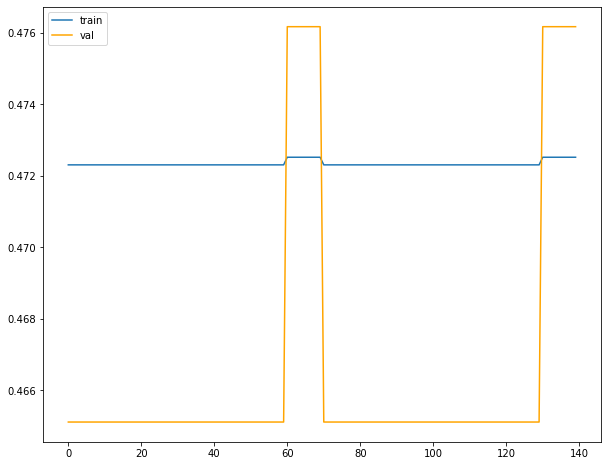

In [62]:
plt.plot(train_score, label="train")
plt.plot(val_score, color="orange", label="val")
plt.legend()

#### 6. Sacar métricas, valorar el modelo 

In [ ]:
# Con el objetivo de encontrar la varianza real del accuracy de nuestro modelo, se puede partir el conjunto de test en N trozos para realizar el score de cada uno de ellos y tener una idea de como es la variación.

In [82]:
model.score(X_test,y_test)

0.27495

In [81]:
j = KFold(n_splits=10)
# val es un trozo que nunca se repite
for (train, val) in j.split(X_test):
    print(model.score(X_test[val], y_test[val]))

0.273
0.275
0.2725
0.295
0.264
0.2795
0.2675
0.2725
0.274
0.2765


#### 7. Si todo OK con el score de test, pasamos a la parte en la que entrenamos el modelo con todos los datos (X,y)

**IMPORTANTE**

Esto podríamos hacerlo con cross validation reentrando desde 0 y así poder ver la evolución de los aciertos/errores en gráfica con todos los datos. 

In [83]:
#model = model elegido para que empiece desde 0 si es lo que queremos, perdiendo lo anteriormente aprendido
model = LogisticRegression(n_jobs=-4, verbose=True, C=1., penalty="l2")

In [84]:
%%time
# Opción para entrenar con todo a la vez. 
model.fit(X_modified.values, y.values)

[Parallel(n_jobs=-4)]: Using backend LokyBackend with 5 concurrent workers.
Wall time: 7.63 s
[Parallel(n_jobs=-4)]: Done   1 out of   1 | elapsed:    7.3s finished


LogisticRegression(n_jobs=-4, verbose=True)

In [86]:
# Este modelo realmente es el que tenemos que guardar

filename = 'models/name_of_model_trained_with_all_data_final_v1.sav'
success, model_filename = save_model(to_save=model, filepath=filename)

Saved successfully


## Una vez listo el modelo, toca predecir con el dataset de predicción 

In [87]:
to_pred = pd.read_csv("healthcare/test_set.csv")

In [88]:
# la primera columna es id_case, deberéis quitarla para hacer la predicción si la habéis quitado para entrenar
# pero guardarla para incluirla en la submission

# IMPORTANTE: APLICAR LO MISMO A ESTOS DATOS QUE HAYÁIS APLICADO A LOS DATOS DE ENTRENAMIENTO
# SI EL ARRAY CON EL QUE HICISTEIS .fit() ERA DE 4 COLUMNAS, PARA .predict() DEBEN SER LAS MISMAS
# SI AL ARRAY CON EL QUE HICISTEIS .fit() LO NORMALIZASTEIS, PARA .predict() DEBÉIS NORMALIZARLO
# TODO IGUAL SALVO BORRAR FILAS, EL NÚMERO DE ROWS SE DEBE MANTENER EN ESTE SET, PUES LA PREDICCIÓN DEBE TENER 133744 FILAS
# SI O SI

to_pred

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,314114,19,a,7,Y,4,gynecology,S,C,2.0,59278,8.0,Emergency,Minor,2,41-50,4778.0
1,208989,15,c,5,Z,3,gynecology,S,F,2.0,102253,15.0,Trauma,Moderate,3,31-40,5734.0
2,305872,17,e,1,X,4,gynecology,R,E,4.0,5828,4.0,Emergency,Minor,3,71-80,5064.0
3,266099,3,c,3,Z,4,TB & Chest disease,R,A,2.0,56642,9.0,Urgent,Extreme,4,31-40,3254.0
4,13228,6,a,6,X,4,gynecology,R,F,1.0,116266,8.0,Emergency,Minor,3,21-30,4639.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133739,318155,18,d,13,Y,6,anesthesia,Q,B,3.0,123269,25.0,Urgent,Minor,4,51-60,5089.0
133740,144850,27,a,7,Y,2,gynecology,S,C,2.0,1293,8.0,Emergency,Moderate,3,61-70,6713.0
133741,180676,16,c,3,Z,3,gynecology,R,A,3.0,112921,5.0,Trauma,Minor,3,31-40,5326.0
133742,39933,28,b,11,X,4,gynecology,R,F,2.0,585,2.0,Trauma,Extreme,2,31-40,7072.0


In [89]:
# para evitar este error ValueError: Input contains NaN, infinity or a value too large for dtype('float64').
#to_pred = to_pred.fillna(0)

In [90]:
used_columns = X_modified.columns.values
used_columns

array(['1', '3', '5', '10', '14', '16', '2', '4', '6', '7', '8', '12',
       '13', '15'], dtype=object)

In [91]:
# Ejecuto la función que transforma el dataframe a predecir
to_pred_modified = my_transformation(df=to_pred)
to_pred_modified

,0,1,3,5,10,14,16,2,4,6,7,8,12,13,15
0,314114,19,7,4,59278,2,4778.0,0,1,2,3,2,0,1,4
1,208989,15,5,3,102253,3,5734.0,2,2,2,3,5,1,2,3
2,305872,17,1,4,5828,3,5064.0,4,0,2,2,4,0,1,7
3,266099,3,3,4,56642,4,3254.0,2,2,0,2,0,2,0,3
4,13228,6,6,4,116266,3,4639.0,0,0,2,2,5,0,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133739,318155,18,13,6,123269,4,5089.0,3,1,1,1,1,2,1,5
133740,144850,27,7,2,1293,3,6713.0,0,1,2,3,2,0,2,6
133741,180676,16,3,3,112921,3,5326.0,2,2,2,2,0,1,1,3
133742,39933,28,11,4,585,2,7072.0,1,0,2,2,5,1,0,3


In [92]:
to_pred_modified[used_columns]

,1,3,5,10,14,16,2,4,6,7,8,12,13,15
0,19,7,4,59278,2,4778.0,0,1,2,3,2,0,1,4
1,15,5,3,102253,3,5734.0,2,2,2,3,5,1,2,3
2,17,1,4,5828,3,5064.0,4,0,2,2,4,0,1,7
3,3,3,4,56642,4,3254.0,2,2,0,2,0,2,0,3
4,6,6,4,116266,3,4639.0,0,0,2,2,5,0,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133739,18,13,6,123269,4,5089.0,3,1,1,1,1,2,1,5
133740,27,7,2,1293,3,6713.0,0,1,2,3,2,0,2,6
133741,16,3,3,112921,3,5326.0,2,2,2,2,0,1,1,3
133742,28,11,4,585,2,7072.0,1,0,2,2,5,1,0,3


In [93]:
%%time
# Realizo la predicción
predictions_submit = model.predict(to_pred_modified[used_columns].values)
predictions_submit

Wall time: 27.9 ms


array(['21-30', '21-30', '21-30', ..., '21-30', '21-30', '21-30'],
      dtype=object)

In [94]:
# Genero mi submission con lo que kaggle quiere que cada usuario suba para luego pasarlo a csv
submission = pd.DataFrame({"id": to_pred["0"], "days": predictions_submit})
submission

,id,days
0,314114,21-30
1,208989,21-30
2,305872,21-30
3,266099,21-30
4,13228,21-30
...,...,...
133739,318155,21-30
133740,144850,21-30
133741,180676,21-30
133742,39933,21-30


#### Comprobamos que mi submission tiene la misma forma que el submission de ejemplo que kaggle deja

In [95]:
sample = pd.read_csv("healthcare/sample_submission.csv")

In [96]:
sample.shape

(133744, 2)

In [98]:
all_ok_to_submit = False
if submission.shape == sample.shape:
    if submission.columns.all() == sample.columns.all():
        if submission.id.all() == sample.id.all():
            submission.to_csv("to_submit_lr_with_nan_mean_d1.csv", index = False)
            all_ok_to_submit = True
            # ¡¡¡¡¡¡¡ADD INDEX = FALSE!!!!!!!!!

if all_ok_to_submit:
    print("you're ready to submit! :)")
else: 
    print("Sorry...There was an error :(")

you're ready to submit! :)
